
<h1 align='center'> 
        Assesing the impact of floodings during the January
        15<sup>th</sup>- January 25<sup>th</sup> pass of storm
        Gloria along the Tordera river, Maresme county, Spain
</h1>

<h4 align='center'>
    by Joseph Doundoulakis
</h4>

<p style="text-align:center">
    <i>M.Eng. Spatial Planning & Development Engineer <br> AI / Machine Learning Expert <br> GIS Expert </i>
</p>


In [1]:
%%capture

"""
Environment Setup.


ATTENTION for virtual environments:
You might need to switch to the locally defined kernel e.g. "eo_code_sample"


Google Earth Engine API - Verification:
During the first run you will be asked to sign-in with your google earth engine account 
and give permission to share data and utilize the platform's resources through this application.
"""

import ee
import geemap
import overpy
import geopandas          as gpd
import matplotlib.pyplot  as plt
import matplotlib.patches as patches

from utils  import _handle_3_10_bug, _init_ee_instance, _vis_params
from glob   import glob
from static import StaticVisualizer

def _clip(image: ee.Image):
    global eeAOI
    return image.clip(eeAOI)

_handle_3_10_bug()
_init_ee_instance()

"Create a StaticVisualizer instance to plot vectorized results."
static_plotter = StaticVisualizer('Region of Interest', crs=32631)

<h3>
    <u>Area of Interest definition:</u>
</h3>
<p style="text-align:justify">
    Part of this assignment asks for the estimation of the affected population by the floodings caused by the storm Gloria, so it is necessary to work with some kind of officially defined administrative divisions of the general area which collect and maintain official demographic data.
</p>

<p style="text-align:justify">
    The municipalities of <b>Tordera</b>, <b>Palafolls</b> and <b>Malgrat de Mar</b> were chosen due to their vicinity to the Tordera river. Their geometries were retrieved from <a href="https://data.opendatasoft.com">https://data.opendatasoft.com</a>.
</p>

In [2]:
"""
Block Objectives:
    1. Get a GEE Map instance for visualization.
    2. Load the municipality shapefiles on memory.
    3. Upload geometries to GEE.
    4. Visualize geometries.
"""

# 1. Get Map instance.
#    The same instance will be used
#    Throughout this document.
Map     = geemap.Map(center=(41.6845, 2.7134), zoom=12)


# 2. Load the municipality shapefiles onto memory.
#    Collect the shapefiles' paths.
paths   = glob("geometries/*/*.shp")

#    Load geometries as GeoDataFrames on memory.
gdfs    = [gpd.read_file(path) for path in paths]


# 3. Upload geometries to GEE.
"This dictionary holds the references to GEE municipality geometries."
eeGEOMS = {
    
    # Key.
    gdf['mun_name'][0]:
    
    # Value.
    
    # Create a ee.Geometry.Polygon
    # instance for every GeoDataFrame.
    ee.Geometry.Polygon(
        
        # GeoDataFrame geometries are
        # Shapely Polygon geometry objects.
        list(
            # The following zip operation
            # brings the xy coordinates
            # in the form expected by
            # ee.Geometry.Polygon constructor.
            zip(*gdf.geometry[0].exterior.xy)
        )
        
    ) for gdf in gdfs
    
}

for name, geom in eeGEOMS.items():
    
    # Add each geometry onto the Map instance.
    Map.addLayer(
        geom,
        name=name
    )

Map

Map(center=[41.6845, 2.7134], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

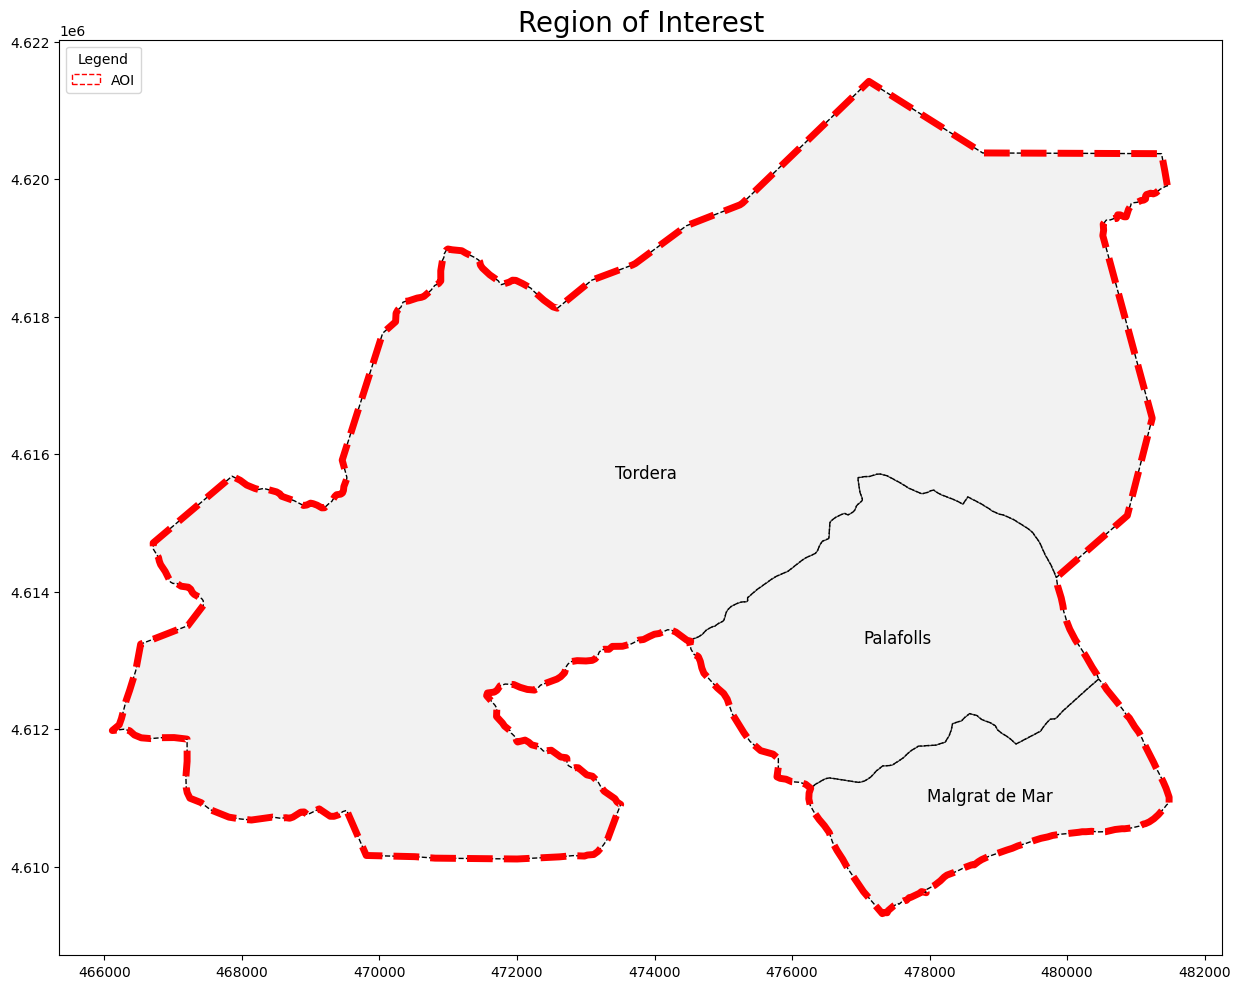

<Figure size 640x480 with 0 Axes>

In [3]:
"Static Visualization for the online notebook version."

import pandas as pd

for gdf in gdfs:

    # Plot geometries.
    static_plotter(gdf,
                   color=(.9, .9, .9, .5),
                   ec=(.0,.0,.0),
                   ls='--',
                   lw=1,
                   text=gdf.mun_name[0],
                   label=gdf.mun_name[0])

# Merge municipalities in a single ROI geometry.
gdfAOI = pd.concat(gdfs).dissolve()

static_plotter(gdfAOI,
               color=(0., 0., 0., 0.),
               ls='--',
               lw=5.,
               ec='red',
               label='AOI')

<p>
<h2> UNIT A: Flood Mapping</h2>
<h4>Area definition, satellite platform choosing, date of interest identification, reference image generation, change detection.</h4>

For this part of the study, taking in account the small study scale and time contraints, it was decided that the most efficient tool to use is
<a href="https://earthengine.google.com/">Google Earth Engine</a>
due to its huge data accessibility.
</p>

<h3> A.1: Inspecting the area during the storm & identifying optimal observation date. </h4>

In [4]:
"""
Block objectives:
    1. Get an area union as ROI.
    2. Gather a collection bounded to ROI.
"""

# 1. Get an area union as ROI.

"Municipality Union will suffice as total ROI."
eeAOI = ee.Geometry.MultiPolygon([poly for poly in eeGEOMS.values()])

"Add Layer to Map instance"
Map.addLayer    (eeAOI, name="AOI")
Map.centerObject(eeAOI)

# 2. Since the storm was actively passing through the region on the 15th onwards,
#    the best approach is to just use SAR sensors which can penetrate clouds.
#    For this reason, a decision was made to proceed with the Copernicus Sentinel-1 GRD collection.

img_collection = (
    ee.ImageCollection("COPERNICUS/S1_GRD")
      .filterBounds   (eeAOI)
      .filterDate     ("2020-01-15", "2020-01-25")
      .sort           ("system:time_start")
      .map            (_clip)
)

num_imgs       = img_collection.size().getInfo()

f"Images found for the requested period: {num_imgs}"

'Images found for the requested period: 8'

<p>
        <b>After defining the ROI and gathering the collection, we should add the images to the map and look for an image that has best captured the impact of storm Gloria in the area.</b>
</p>

In [5]:
"""
Block Objectives:
    1. Identify the optimal image for impact inspection.
"""

img_list = img_collection.toList(
    img_collection.size()
)

for i in range(num_imgs):
    """
    Iterate through the collection
    and plot images for inspection.
    """
    
    "Convert ComputedObjects to Images."
    img  = ee.Image(img_list.get(i))
    
    "Extract sensing time start as name."
    name = img.get("system:index").getInfo().split("_")[4]
    
    "Add it ot the Map instance."
    Map.addLayer(
        img, _vis_params, name=name, shown=name == "20200122T055311"
    )

"""
Through image inspection we can easily
identify that the image taken on 2020/01/22
at 05:53:11 is the most representetive of
the floodings peak.

The image contains the most signs of weak
signals that are not present in other images,
which represent the existance of water bodies
of significant size.
"""

"Create a reference to the image of interest"
flood_img = img_collection.filter(
    ee.Filter.stringContains("system:index", "20200122T055311")
).first()

Map

Map(center=[41.6845, 2.7134], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

<p>
    As described within the code block, by inspecting the available images we can identify the image <b>"20200122T055311"</b> standing out as it shows the most signs of weak signal reception -- characteristic of microwaves bouncing off the smooth surface of water bodies and never returning back to the sensor.
</p>

<h3>
    A.2: Generating a reference image with minimum noise.
</h3>

<p style='text-align:justify'>
    In order to generate a reliable reference image for change detection, it is an absolute neccessity to pay attention to scattering noise and potential sources of it, as SAR sensors are highly susceptible to noise.
    In particular, when comparing SAR images, the angle of reception (and transmission) plays a crucial role since it could generate an entirely different response from the viewed landscape.

<h8>A few things can be done to mitigate this effect. </h8>
<ol>
    <li>
        Using a lowpass filter (e.g. gaussian or median).
    </li>
    <li>
        Comparing images from the same sensor, platform, same pass direction, same relative orbit (identical acquisitions).
    </li>
    <li>
        Using an time-wise averaged composite of identical acquisitions.
    </li>
</ol>
    
</p>

In [6]:
"Collect metadata from the image of interest."
info = {
    "relativeOrbitNumber_start": flood_img.get("relativeOrbitNumber_start").getInfo(),
    "orbitProperties_pass"     : flood_img.get("orbitProperties_pass")     .getInfo(),
    "platform_number"          : flood_img.get("platform_number")          .getInfo()
}

"Generate a reference image based on collected metadata."
reference_img = (

    ee.ImageCollection("COPERNICUS/S1_GRD")
      .filterBounds   (eeAOI)
    
      # The reference image was constructed from
      # a period of 1.5-2 months in the past.
    
      # This was generally a random choice,
      # but you can go further back if you
      # construct it using the median values.
    
      # Otherwise, using "mean" could infect the
      # generated image with outliers. In that
      # case the most recent past should probably
      # be favored.
      
      # Additionally, there is the issue of wet/dry seasons.
      # Reference should be close to observed seasonality.

      .filterDate     ("2019-12-01", "2020-01-18")
      .filter(
          ee.Filter.eq("relativeOrbitNumber_start",
                       info["relativeOrbitNumber_start"])
      )
      .filter(
          ee.Filter.eq("orbitProperties_pass",
                       info["orbitProperties_pass"])
      )
      .filter(
          ee.Filter.eq("platform_number",
                       info["platform_number"])
      )
      .map   (_clip)
      .median()
      
    
      # While not shown here, this filtered
      # collection resulted in 4 images.
    
      # So the Reference Image is a median
      # composite of 4 images.
)

"Apply a 3x3 lowpass filter to flood_image"
flood_img = flood_img.focalMedian(1.5, 'square')

"Add reference image to Map instance."
Map.addLayer(reference_img, _vis_params, name='Reference')
Map

Map(center=[41.6845, 2.7134], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

<p>
    The generated reference image appears smooth and with minimal noise.
</p>
    

<h3>
    A.3: Change Detection & Flooded Area Mapping
</h3>

<p>
    After establishing both of our images, we can proceed with change detection.
</p>

<p style='text-align:justify'>
    To detect the change, a subtraction is performed between the reference image and the floods observation image. The highest values in the resulting image represent the biggest change in the landscape's state. Since the flood observation image will be subtracted from the reference image, the high values of their difference will represent previously dry regions that now are covered in water.
</p>
    

In [7]:
# Produce change raster.
change = (
    reference_img.subtract(flood_img)
                 
                 # Flooded area masking:
                 # Simple threshold of visual appeal.
    
                 # A statistical approach could have been
                 # used instead for the derivation of a better
                 # theshold, but this will suffice for this case.
        
                 .gt(2.2)
                 
                 # Frequence filtering
                 # on 7x7 window.
                 .focalMode(3.5, 'square')
                 
                 # Select band for use.
                 # A water detection indice would
                 # probably be more accurate.
                 # 
                 # Note: I have seen papers suggesting VH 
                 # polarization is better for water detection,
                 # but in this case VV seems to produce better results.
                 .select('VV')
    
                 # Convert to Integer for Vectorization.
                 .toInt()
    
                 # Vectorize raster mask
                 # and keep flood area vectors
                 # larger than 50 pixels of size.
                 .reduceToVectors(scale=10., crs="EPSG:32631", maxPixels=1e10)
                 .filter  (
                 
                     ee.Filter.eq("label", 1)
                     
                 )
                 .filter  (
                     
                     ee.Filter.gt("count", 50)
                 
                 )
)



Map.addLayer(change,
             {'color': 'red'},
             name='Floodings',
             opacity=.5)
Map

Map(center=[41.6845, 2.7134], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

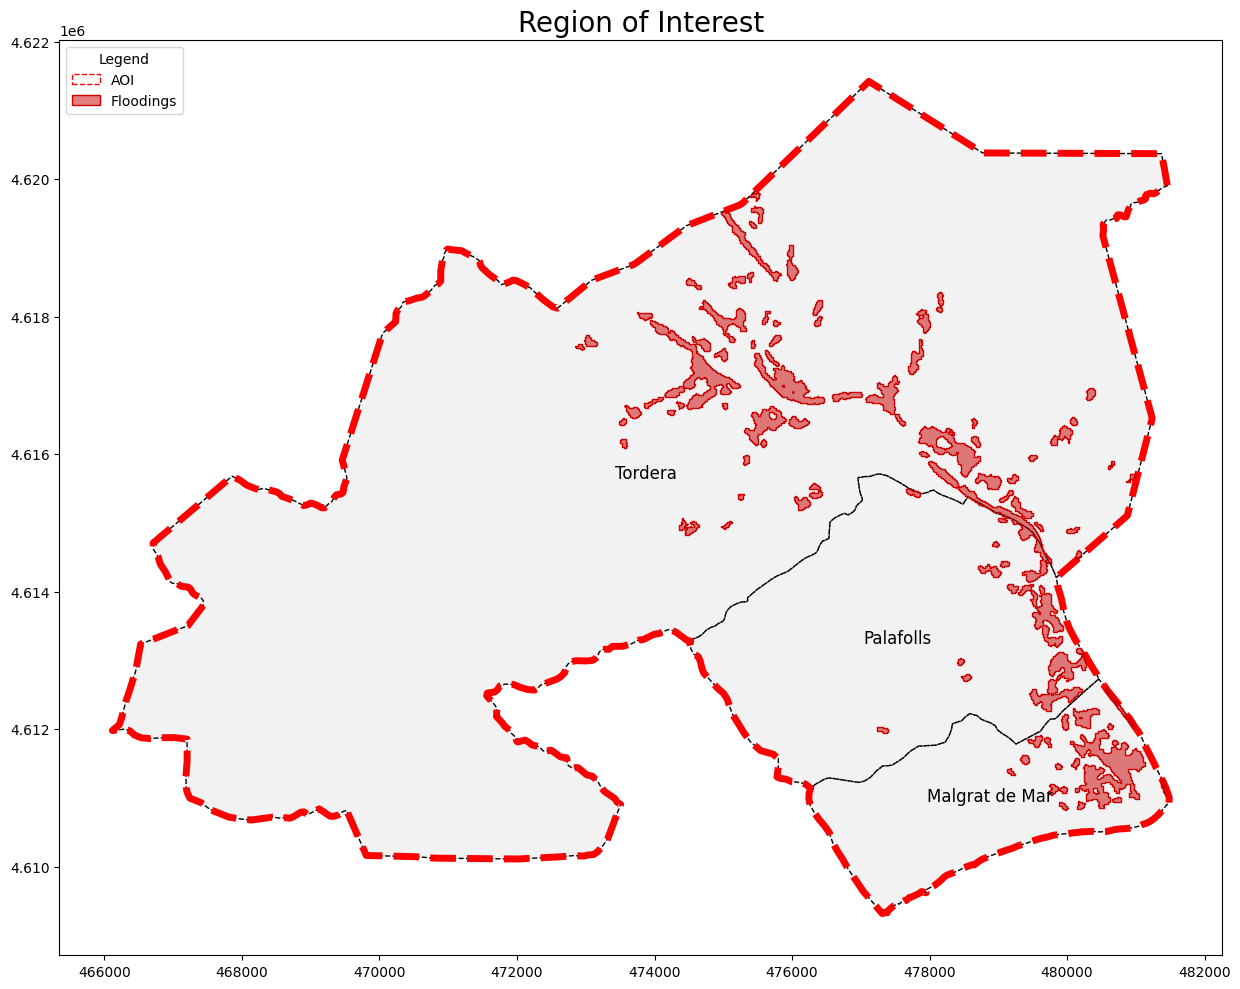

<Figure size 640x480 with 0 Axes>

In [8]:
"Static Visualization for the online notebook version."

from shapely.geometry import Polygon

gdfFLOODS = gpd.GeoDataFrame(
    geometry=[
        Polygon(x[0], holes=x[1:])
        for x in change.geometry().getInfo()['coordinates']
    ],
    crs=4326
).buffer(0)

static_plotter(gdfFLOODS,
               color=(.8, .0, .0, .5),
               ec=(.8, .0, .0, 1.),
               label='Floodings',
               lw=1,
               ls='-')

<h3>
    A.4: Flooded Area Estimation
</h3>

<p>
    Now that we have delineated a good estimation of the flooded areas, we should convert the CRS from EPSG:4326 to a projected system and measure the area. We will use the corresponding UTM Zone for that region, which according to <a href="https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#">this</a> website is <b>UTM Zone 31N</b>.
</p>

In [9]:
"EPSG code for UTM 31N is 32631 -> https://epsg.io/32631"
area = change.geometry().area(1e-3, "EPSG:32631").getInfo()

f"Estimation of total flooded area: {round(area / (1000 * 1000), 2)} sq. km."

'Estimation of total flooded area: 3.7 sq. km.'

<p>
    The <b>total flooded area</b> caused by Gloria's passing in those areas is then estimated to be around <b>3.8 km<sup>2</sup></b>.
</p>
<p>
However, it would be more appropriate to first mask out the extent of the Tordera river and not include any area changes within its borders, as those areas are not likely to have any impact on landscape, infrastructure and/or society.
</p>
<p>
    <b><i>This will not be done for this study.</i></b>
</p>
    

<h2>
    UNIT B: Estimating the affected population.
</h2>

<p style="text-align:justify">
    As mentioned earlier in this document, in order to derive an estimation of the affected population, the area has to be broken down to its defined administrative divisions which collect and maintain official demographic data.
</p>

<p style="text-align:justify">
    Geometries are downloaded for the municipalities of Tordera, Palafolls and Malgrat de Mar from <a href="https://data.opendatasoft.com">https://data.opendatasoft.com</a>.
</p>

<p style="text-align:justify;">
    <b><u>Disclaimer</u>:</b> <i style="color:#333">For the purpose of this study/assessment, the population is assumed to be distributed <b>uniformly</b> thoughout the urban areas of each administrative division (municipality, in this case). In reality we would need the shapefiles and demographics of each affected city within the municipalities. Ideally, we would use a layer with all building geometries, if it was in our disposal. Additionally, for a much better estimation, fine scale population density maps and/or 3D surface models should be used. The following is merely a demostration of <b>technical skills</b> and does not reflect reality.</i> 
</p>

<h3>
    B.1: Retrieving polygons of Urban Areas.
</h3>

<p style="text-align:justify">
    Since the population is assumed to be residing within urban areas, it is essential to include the geometries of those urban areas within our region of interest in order to derive a more accurate estimation of the affected population.
</p>

<p>
    Google Earth Engine provides access to multiple versions of the <a href="https://land.copernicus.eu/pan-european/corine-land-cover">Corine Land Cover</a> dataset, from which we will use the most recent.
</p>


In [10]:
"""
Block Objectives:
    1. Get the corine land cover collection.
    2. Vectorize the urban areas.
"""

urban = (
    ee.ImageCollection("COPERNICUS/CORINE/V20/100m")
      
      # Sort Images to most recent first.
      .sort("system:index", False)
      
      # Extract the most recent Image.
      .first()
    
      # Clip ee.Image
      .clip(eeAOI)
      
      # Keep the urban fabric labels only.
      # Labels 111 & 112 according to CLC legend.
      .lt(113)
    
      # Vectorize
      .reduceToVectors(scale=10., crs="EPSG:32631", maxPixels=1e10)
      .filter(
          ee.Filter.eq("label", 1)
      )
)

Map.addLayer(urban,
             {'color': 'black'},
             name='Urban Fabric',
             opacity=.9)
Map

Map(center=[41.68979957906288, 2.6853239650000003], controls=(WidgetControl(options=['position', 'transparent_…

<p>
    The above visualization demonstrates the urban areas in the collective region, according to Corine Land Cover.
</p>

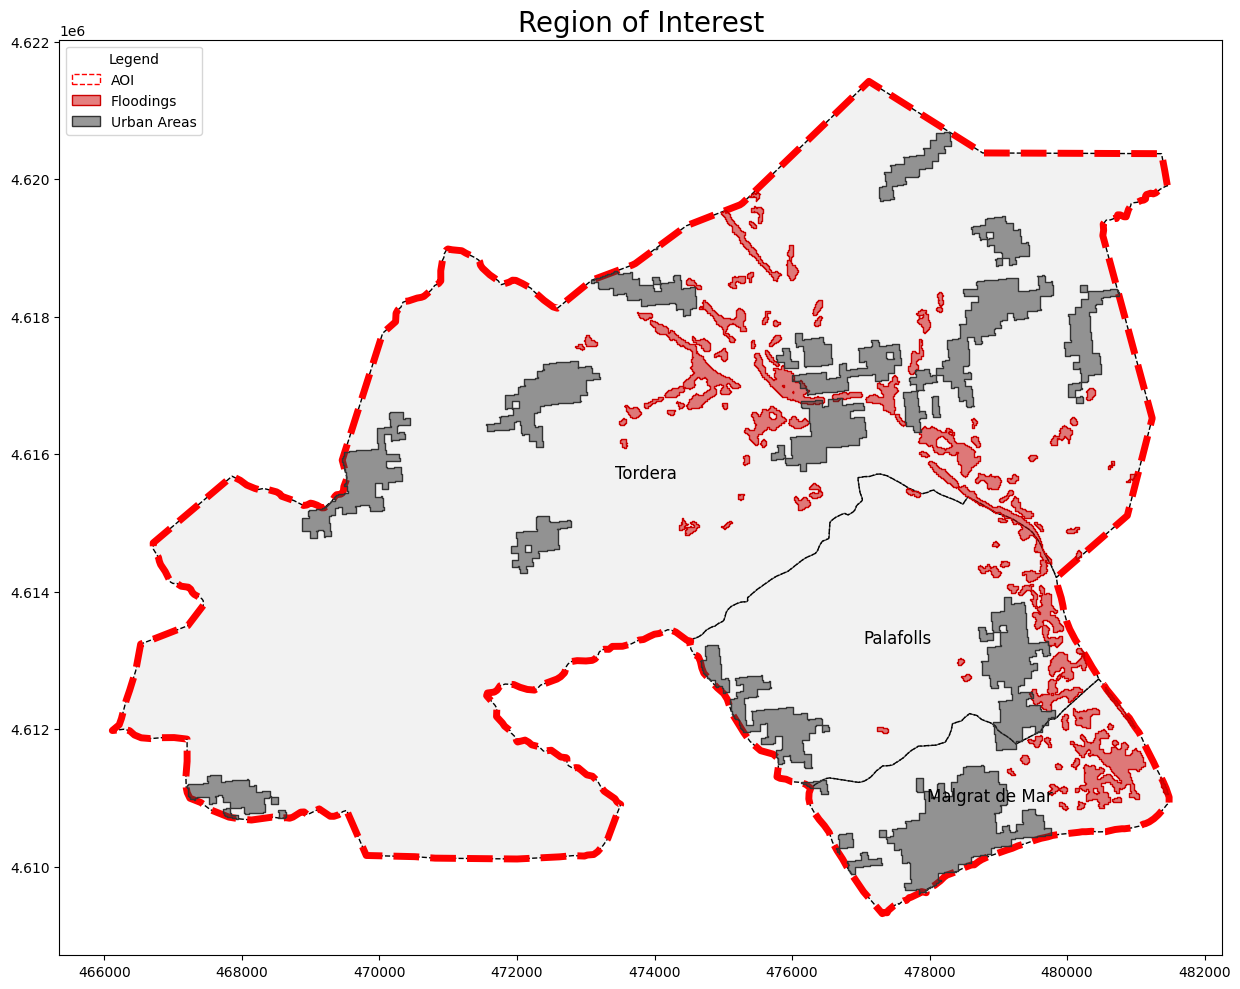

<Figure size 640x480 with 0 Axes>

In [11]:
"Static Visualization for the online notebook version."

gdfURBAN = gpd.GeoDataFrame(
    geometry=[Polygon(x[0], x[1:]) for x in urban.geometry().getInfo()['coordinates']],
    crs=4326
).buffer(0)

static_plotter(gdfURBAN,
               color=(.2, .2, .2, .5),
               ec=(.2, .2, .2, 1.),
               lw=1,
               ls='-',
               label='Urban Areas',
               zorder=1)

<h3>
    B.2: Calculating urban areas and flooded urban areas per municipality.
</h3>

<p>
    We will proceed with calculating an urban area impact factor for each municipality, which essentially will indicate the percentage of urban area affected by the floods. The formula would look something like:
</p>

$$
I_{urban}=\frac{Area^{flooded}_{urban}}{Area^{total}_{urban}}
\tag{1}
$$

In [12]:
"""
Block Objectives:
    1. Calculate the urban area of each municipality.
    2. Calculate the flooded urban area per municipality.
    3. Calculate the fraction of urban area affected
       as an indicator of urban population impact.
"""

eeURBAN   = {
    
    # 1. Calculate the urban area
    #    of each municipality.
    
    #    The area of Urban Fabric belonging
    #    to each municipality.
    
    #    Intersection of Urban Fabric
    #    and each municipality.
    key: urban.geometry().intersection(value, 1e-3, "EPSG:32631")
    
    #    eeGEOMS holds the municipalities'
    #    boundaries.
    for key, value in eeGEOMS.items()
    
}

eeFLOODED = {
    
    # 2. Calculate the flooded urban area
    #    per municipality.
    
    #    The area of each municipality's
    #    Urban Fabric affected by the floods.
    
    #    Intersection of Urban Fabric and floodings.
    key: change.geometry().intersection(value, 1e-3, "EPSG:32631")
    
    for key, value in eeURBAN.items()
    
}

impactFactors = {
    
    # 3. Calculate the fraction of urban area affected
    #    as an indicator of urban population impact.
    
    key:
    round(
    eeFLOODED[key].area(1e-3, "EPSG:32631").getInfo()
    / eeURBAN[key].area(1e-3, "EPSG:32631").getInfo()
    
    * 100,
        2
    )
    
    for key in eeFLOODED.keys()
}

impactFactors

{'Malgrat de Mar': 0.0, 'Palafolls': 0.2, 'Tordera': 0.42}

<p style="text-align:justify">
    From the above calculations, we can see that an insignificant percentage of total urban areas per municipality are affected due to the floodings. Just 0.2% for the municipality of Palafolls and just over 0.4% for the municipality of Tordera.
</p>

<table>
     <caption>Table 1: Estimated impact factor per municipality.</caption>
    <tr>
        <th>
            Municipality
        </th>
        <th>
            Impact factor
        </th>
    </tr>
    <tr>
        <td>
            Malgrat de Mar
        </td>
        <td>
            0%
        </td>
    </tr>
    <tr>
        <td>
            Palafolls
        </td>
        <td>
            0.2%
        </td>
    </tr>
    <tr>
        <td>
            Tordera
        </td>
        <td>
            0.42%
        </td>
    </tr>
</table>

<h3>
    B.3: Estimating the affected population.
</h3>

<p style="text-align:justify">
    Again, normally this calculation has to at least be performed on city level (finer level), or ideally using very fine scale land cover and nDSM rasters in order to have accurate estimations. The numbers presented here are assuming a uniform population density across the entire municipality. This assumption is completely unrealistic and it is only taken for demonstration purposes.
</p>

<p style="text-align:justify">
    Now, using this assumption and exploiting the correlation of population and built-up space, we can deduct that a similar percentage of population $\bf I_{pop}$ was impacted in each municipality, such as that:
    $$
    I_{pop}=I_{urban}
    \tag{2}
    $$
</p>

<p style="text-align:justify">
    For the purposes of this study/assessment outdated population data were retrieved from the provided wikipedia page for the county of <a href="https://en.wikipedia.org/wiki/Maresme">Maresme</a>. Ideally, the population data would be retrieved from the corresponding official statistical authorities associated with the areas.
</p>

<p>
    In particular, the following population estimations will be used:
</p>
    
<table>
     <caption>Table 2: Population per municipality.</caption>
    <tr>
        <th>
            Municipality
        </th>
        <th>
            Population (2014)
        </th>
    </tr>
    <tr>
        <td>
            Malgrat de Mar
        </td>
        <td>
            18,417
        </td>
    </tr>
    <tr>
        <td>
            Palafolls
        </td>
        <td>
            9,065
        </td>
    </tr>
    <tr>
        <td>
            Tordera
        </td>
        <td>
            16,345
        </td>
    </tr>
</table>

<p>
      The affected urban population will be estimated per municipality as:
</p>

$$
Population_{affected} = Population_{total} * I_{pop}
\tag{3}
$$

In [13]:
"""
Block Objective:
    1. Estimate the affected urban population.
"""

population = {
    "Malgrat de Mar": 18417,
    "Palafolls"     : 9065 ,
    "Tordera"       : 16345 
}


affectedPopulation = {
    
    # Using equations (1), (2) and (3)
    
    # Estimate the affected urban population.
    # per municipality.
    
    # Note: Impact factors are in the form of
    #       percentages and not fractions.
    key: population[key] * impactFactors[key] / 100
    
    for key in population.keys()
}

affectedPopulation

{'Malgrat de Mar': 0.0, 'Palafolls': 18.13, 'Tordera': 68.649}

<p>
    About <b>70 people</b> are estimated to have been affected in the municipality of Tordera and another <b>20 people</b> in the municipality of Palafolls, making a total sum of about <b>90 people</b> according to the data used.
</p>

<table>
     <caption>Table 3: Estimated affected urban population per municipality.</caption>
    <tr>
        <th>
            Municipality
        </th>
        <th>
            Estimated affected population
        </th>
    </tr>
    <tr>
        <td>
            Malgrat de Mar
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            Palafolls
        </td>
        <td>
            20
        </td>
    </tr>
    <tr>
        <td>
            Tordera
        </td>
        <td>
            70
        </td>
    </tr>
    <tr>
        <th>
            Total
        </th>
        <th>
            90
        </th>
    </tr>
</table>

<h2>
    UNIT C: Estimating the affected road infrastructure.
</h2>
<p>
    This unit will be dedicated for the assessment of the affected roads.
</p>

<p>
    The road vectors will be retrieved from <a href="https://www.openstreetmap.org/">Open Street Map</a> using their OverPass API.
</p>

In [14]:
"Get an OverPass API instance"
osm        = overpy.Overpass()

<h3>
    C.1: Retrieving the road network vectors from OSM for our area of interest.
</h3>

<p>
    OSM's <a href="https://wiki.openstreetmap.org/wiki/Overpass_API">OverPass API</a> supports its own query language for fetching desired subsets of the OSM map data.
</p>

In [15]:
"""
Block Objectives:
    1. Fetch road network vectors from OSM.
    2. Identify distinct road types.
"""

# 1.  Fetch road network vectors from OSM.

#     Query the desired data.
result = osm.query(
        
        # Query all the "highway"
        # nodes intersected with the 
        # Maresme comarca boundaries.
    
        # TODO
        # Size down the query a bit.
        # Sometimes returns high load errors.
    
        """
        (area[name="Maresme"];)->.a;
        way["highway"](area.a);
        (._;>;);
        out;
        """

)

#     Create an ee.FeatureCollection instance
#     out of multiple ee.Feature instances
#     from each way of the queried result.

#     The query result contains a collection of "ways"
#     which are basically geometries with metadata.

#     Each way consists of multiple nodes and
#     each node consists of a pair of coordinates.

#     The metadata of the geometries are contained
#     in the attribute "tags"

# 2.  Identify distinct road types.
road_types = set([way.tags['highway'] for way in result.ways])
road_types

{'bus_stop',
 'construction',
 'corridor',
 'cycleway',
 'elevator',
 'footway',
 'living_street',
 'motorway',
 'motorway_link',
 'path',
 'pedestrian',
 'platform',
 'primary',
 'primary_link',
 'proposed',
 'raceway',
 'residential',
 'rest_area',
 'secondary',
 'secondary_link',
 'service',
 'services',
 'steps',
 'tertiary',
 'tertiary_link',
 'track',
 'trunk',
 'trunk_link',
 'unclassified'}

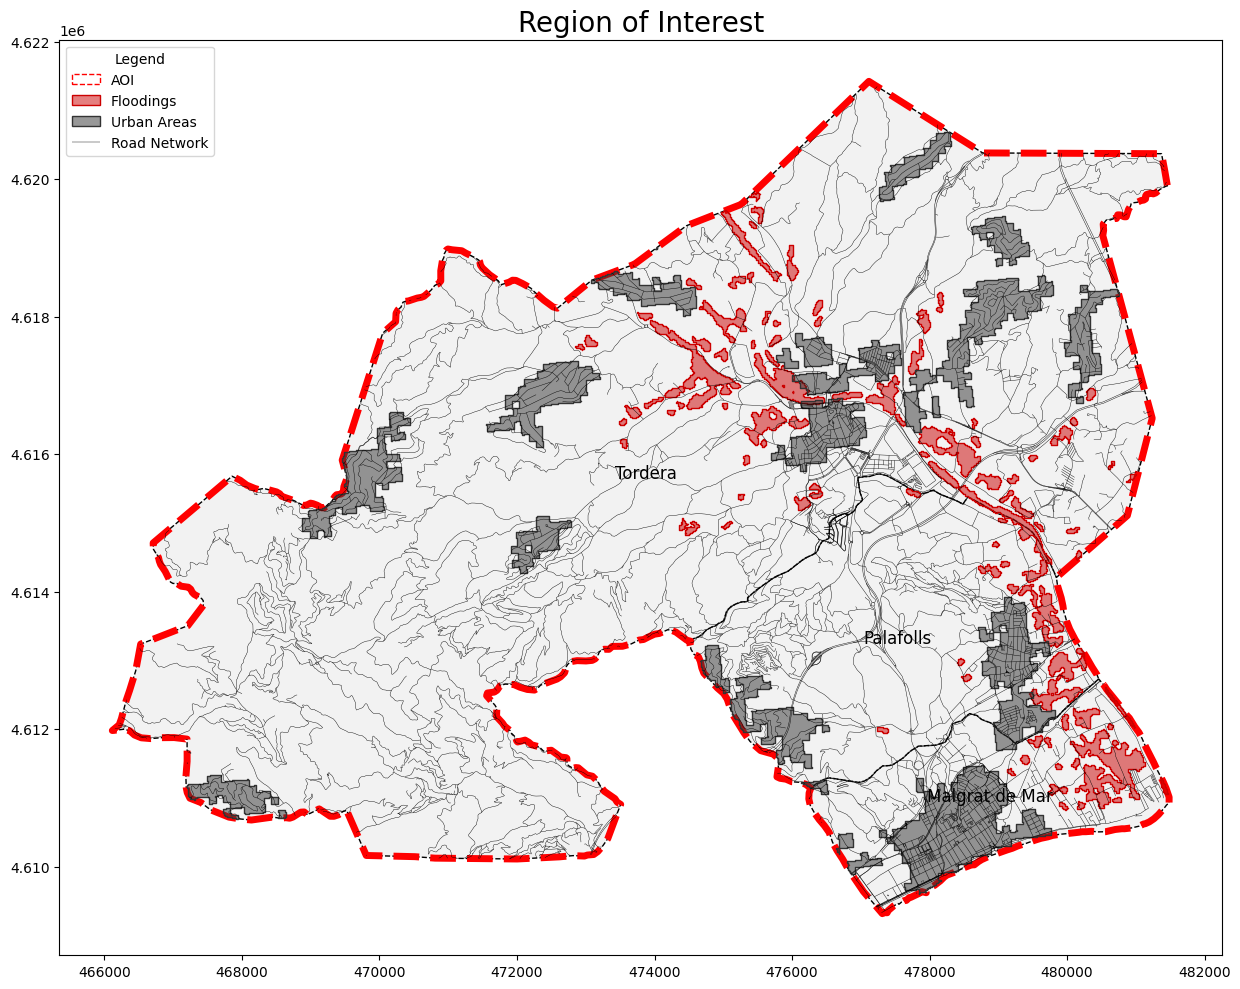

<Figure size 640x480 with 0 Axes>

In [16]:
"Static Visualization for the online notebook version."

from shapely.geometry import LineString

gdfROADNET = (
    
    gpd.GeoDataFrame(
    geometry=[
        LineString(
            [(node.lon, node.lat)
            for node in way.nodes]
        )
        
        for way in result.ways
    ],
    crs=4326
)
    
    .clip  (gdfAOI)
    
)

gdfROADNET.to_crs(32631).plot(ax=static_plotter.ax,
                              legend=True,
                              color='k',
                              lw=.3,
                              label='Road Network')

static_plotter.ax.legend(
    handles=[*static_plotter.handles,
             *static_plotter.ax.get_legend_handles_labels()[0]],
    title='Legend', loc=2
)
static_plotter.fig

<h3>
    C.2: Deriving affected road geometries.
</h3>
<p>
    Calculating the intersection of each feature collection with the flooded areas and deriving the total affected road lenght in km.
</p>
    

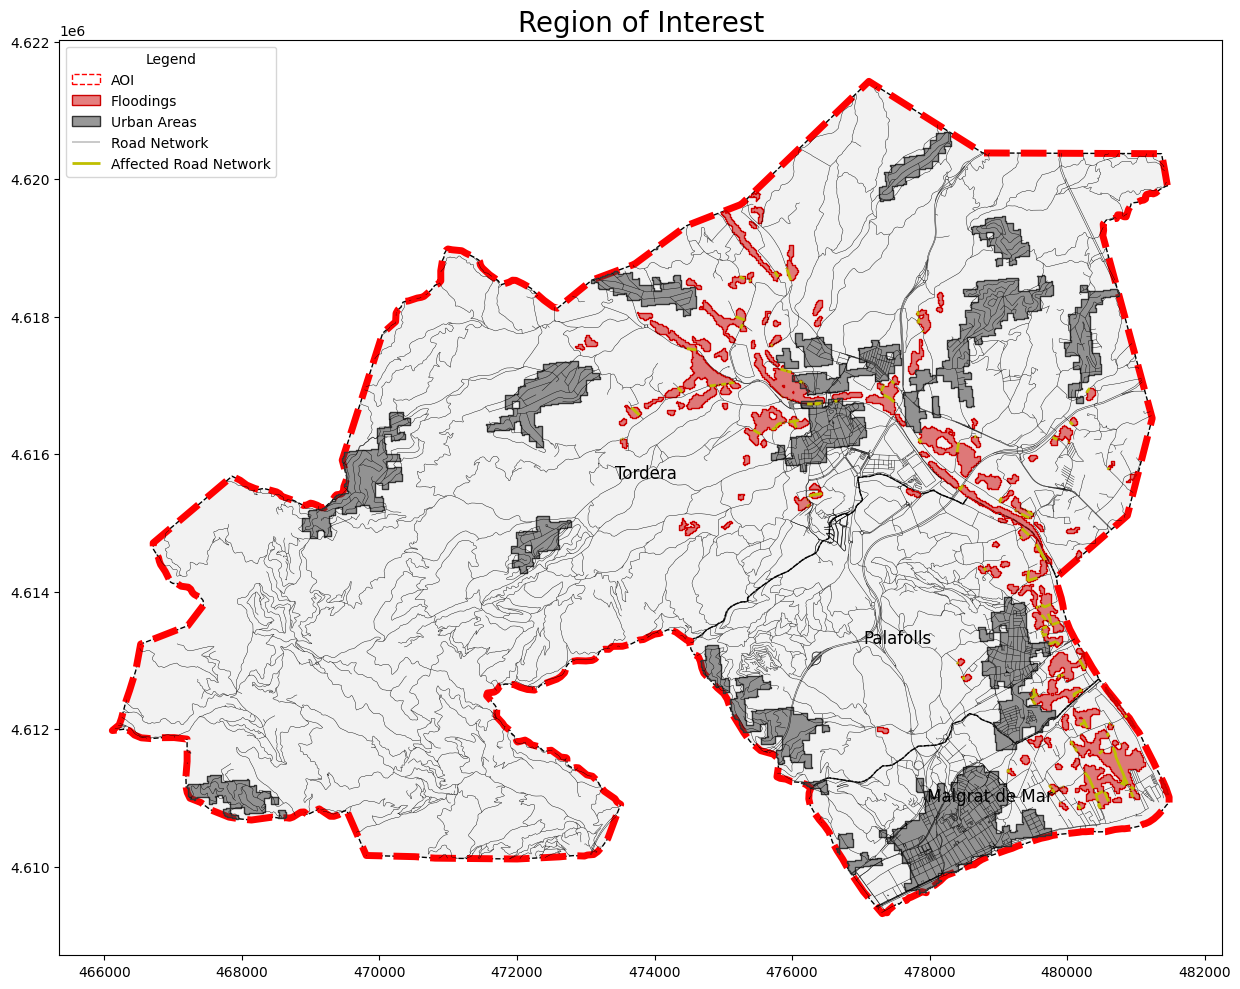

<Figure size 640x480 with 0 Axes>

In [17]:
"""
Block Objectives
    1. Derive flood affected geometries.
    2. Visualize them on Map instance.
"""

#     Create an ee.FeatureCollection instance
#     out of multiple ee.Feature instances
#     from each way of the queried result.

#     The query result contains a collection of "ways"
#     which are basically geometries with metadata.

#     Each way consists of multiple nodes and
#     each node consists of a pair of coordinates.

#     The metadata of the geometries are contained
#     in the attribute "tags"

# 1. Derive flood affected geometries.
# 
#    Results are clipped immediately 
#    to produce smaller sized data
#    for handling convenience.

affected_roads = {
    
    # One collection per road type.
    
    # Key:
    road_type:
    
    # Value:
    ee.FeatureCollection
    (
    
    # Collect the Features in a list.
    # One Feature per "way" included in result.
    # List of Features:
    [
        ee.Feature(
        
            # Add the Feature Geometry.
            ee.Geometry.LineString(

                [
                    [float(node.lon), float(node.lat)]
                    for node in way.nodes
                ],
                proj="EPSG:4326"
            )
            
            # Restrict geometries within flooded areas.
            .intersection(change, 1e-3, "EPSG:32631")
            
            ,
            
            # Add the geometry metadata.
            {
                
                'label': way.tags['highway']
                
            }
            
        )
        
        for way in result.ways
        if way.tags['highway'] == road_type
    ]

    )

    for road_type in road_types
    
}

# 2. Visualize affected road network.
#    Static Visualization for the online notebook version.
# 
#    Also geemap Map instance was clogging badly, so
#    we are plotting locally instead.
#

"Get the intersection of road and flood geometries."
gdfAFFNET = gdfROADNET.clip(gdfFLOODS)

"Reproject to 32631 and plot."
gdfAFFNET.to_crs(32631).plot(ax=static_plotter.ax,
                             legend=True,
                             color='y',
                             lw=2,
                             label='Affected Road Network')

"Update the legend."
static_plotter.ax.legend(
    handles=[*static_plotter.handles,
             *static_plotter.ax.get_legend_handles_labels()[0]],
    title='Legend', loc=2
)

"Return the figure."
static_plotter.fig

<h3>
    C.3: Calculating the total road length affected per road type.
</h3>

<p>
    Using the above derived geometry intersections that represent the affected roads, we will calculate the total length affected for each road type and present the final results.
</p>

In [18]:
"""
Block Objectives:
    1. Produce a dictionary of affected
       road lengths for presentation.
"""

# Get the length of each affected
# road type in meters.

# This will probably take a while.
# Apologies.

affected_lengths = {
    
    # Key:
    road_type:
    
    # Get the length of geometry.
    # Value:
    affected_roads[road_type]
    .geometry(1e-3)
    .length(1e-3, "EPSG:32631")
    .getInfo()
    
    # For every road type.
    for road_type in road_types
}

affected_lengths = {
    
    # Key:
    road_type:
    
    # Value:
    round(length, 2)
    
    # Get rid of unaffected types.
    # Don't include if length is zero.
    
    for road_type, length in affected_lengths.items()
    if length
    
}

affected_lengths

{'footway': 517.02,
 'service': 13.38,
 'cycleway': 5.72,
 'motorway': 114.26,
 'secondary': 238.56,
 'unclassified': 423.91,
 'tertiary': 822.21,
 'residential': 91.52,
 'track': 5946.42,
 'path': 1134.19}

<p>
    The resulted affected road lengths per road types then are as follows:
</p>

<table>
    <caption>Table 4: Total affected length per type of road.</caption>
    <tr>
        <th>
            Road Type
        </th>
        <th>
            Length (m)
        </th>
    </tr>
    <tr>
        <td>
            track
        </td>
        <td>
            3833.45
        </td>
    </tr>
    <tr>
        <td>
            tertiary
        </td>
        <td>
            822.2
        </td>
    </tr>
    <tr>
        <td>
            unclassified
        </td>
        <td>
            532.47
        </td>
    </tr>
    <tr>
        <td>
            path
        </td>
        <td>
            500.84
        </td>
    </tr>
    <tr>
        <td>
            footway
        </td>
        <td>
            473.98
        </td>
    </tr>
    <tr>
        <td>
            secondary
        </td>
        <td>
            248.67
        </td>
    </tr>
    <tr>
        <td>
            motorway
        </td>
        <td>
            114.26
        </td>
    </tr>
    <tr>
        <td>
            service
        </td>
        <td>
            73.55
        </td>
    </tr>
    <tr>
        <td>
            residential
        </td>
        <td>
            16.09
        </td>
    </tr>
     <tr>
        <td>
            cycleway
        </td>
        <td>
            5.72
        </td>
    </tr>
</table>
    